In [696]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations

In [697]:

# Function to visualize the graph
def visualize_graph(graph, title="Graph Visualization"):
    """
    Visualizes a graph using matplotlib.

    Args:
        graph (nx.Graph): The input graph.
        title (str): Title of the graph visualization.
    """
    pos = nx.spring_layout(graph)  # Positions for all nodes
    plt.figure(figsize=(12, 8))
    nx.draw(
        graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", 
        node_size=500, font_size=10, font_color="black"
    )
    plt.title(title, fontsize=16)
    plt.show()

# Function to compare two graphs visually
def compare_graphs(graph1, graph2, title1="Graph 1", title2="Graph 2"):
    """
    Visualizes two graphs side by side for comparison.

    Args:
        graph1 (nx.Graph): The first graph.
        graph2 (nx.Graph): The second graph.
        title1 (str): Title for the first graph.
        title2 (str): Title for the second graph.
    """
    pos1 = nx.spring_layout(graph1)
    pos2 = nx.spring_layout(graph2)

    plt.figure(figsize=(18, 8))

    # Plot graph 1
    plt.subplot(121)
    nx.draw(
        graph1, pos1, with_labels=True, node_color="lightblue", edge_color="gray", 
        node_size=500, font_size=10, font_color="black"
    )
    plt.title(title1, fontsize=16)

    # Plot graph 2
    plt.subplot(122)
    nx.draw(
        graph2, pos2, with_labels=True, node_color="lightgreen", edge_color="gray", 
        node_size=500, font_size=10, font_color="black"
    )
    plt.title(title2, fontsize=16)

    plt.show()


In [698]:
def compute_k_neighborhood_isomorphism_violations(
    G, 
    k_min=5, 
    k_max=30, 
    step=5,
    include_node_itself=False
):
    """
    Per ogni k in [k_min .. k_max], calcola la % di nodi per cui esistono
    meno di k-1 (oppure k, se include_node_itself=False) sub-grafi isomorfi
    al proprio vicinato.
    
    Parametri:
      G: il grafo
      k_min, k_max, step: range di k
      include_node_itself: se False, il conteggio richiede che esistano
                           k-1 ALTRI nodi con lo stesso sub-grafo.
                           Se True, allora basta contare k nodi totali
                           compreso se stesso.
    """
    violations_percentage = {}
    total_nodes = len(G.nodes())

    # Pre-calcoliamo i sub-grafi di vicinato
    # Per node, estraiamo SubG = G.subgraph(neighbors(node))
    neighborhood_subgraphs = {}
    for node in G.nodes():
        neigh = set(G.neighbors(node))
        neighborhood_subgraphs[node] = G.subgraph(neigh).copy()

    # Per semplificare la logica, costruiamo un "gruppo" di isomorfismo
    #   -> isomorphism_class[node] = un ID univoco per il sub-grafo
    # Se due sub-grafi sono isomorfi, avranno lo stesso ID.
    # Implementazione naive: confrontiamo i sub-grafi di ogni coppia di nodi.
    # Attenzione, O(n^2) isomorphism checks => costoso per n grande.
    isomorphism_class = {}
    next_iso_id = 0

    # Lista ordinata dei nodi, così abbiamo un riferimento fisso
    nodes_list = list(G.nodes())

    for i, n1 in enumerate(nodes_list):
        if n1 in isomorphism_class:
            continue  # Già assegnato a una classe

        # Creiamo una nuova classe di isomorfismo
        current_iso_id = next_iso_id
        next_iso_id += 1
        isomorphism_class[n1] = current_iso_id

        subg_n1 = neighborhood_subgraphs[n1]

        # Cerchiamo tutti i nodi n2 che hanno un sub-grafo isomorfo
        for n2 in nodes_list[i+1:]:
            if n2 not in isomorphism_class:  # se non è già assegnato
                subg_n2 = neighborhood_subgraphs[n2]
                # Controllo isomorfismo
                if nx.is_isomorphic(subg_n1, subg_n2):
                    isomorphism_class[n2] = current_iso_id

    # Adesso raggruppiamo i nodi per iso_id
    iso_groups = defaultdict(list)
    for node, iso_id in isomorphism_class.items():
        iso_groups[iso_id].append(node)

    # iso_groups[iso_id] è la lista di nodi che hanno un sub-grafo di vicinato isomorfo
    
    # Calcoliamo le violazioni per i diversi k
    for k in range(k_min, k_max + 1, step):
        violation_count = 0

        for node in G.nodes():
            iso_id = isomorphism_class[node]
            group_size = len(iso_groups[iso_id])
            
            # Se "include_node_itself" == False, allora servono ALTRI k-1 nodi,
            #   quindi group_size >= k
            needed = k if not include_node_itself else k  # volendo puoi cambiare logica
            if group_size < needed:
                violation_count += 1
        
        violation_percentage = (violation_count / total_nodes) * 100
        violations_percentage[k] = violation_percentage

    return violations_percentage


In [699]:


# =============================================================================
#                           FUNZIONI DI SUPPORTO
# =============================================================================

def get_neighborhood_components(graph, vertex):
    """
    Estrae le componenti connesse del sotto-grafo indotto dai vicini di 'vertex'.
    """
    neighbors = set(graph.neighbors(vertex))
    subgraph = graph.subgraph(neighbors)
    return [subgraph.subgraph(c).copy() for c in nx.connected_components(subgraph)]


def get_dfs_code(graph):
    """
    Restituisce un DFS code canonico per il grafo in input, come tupla di archi ordinati.
    """
    canonical_code = None
    sorted_nodes = sorted(graph.nodes())

    for start_node in sorted_nodes:
        visited = set()
        edges = []
        stack = [(start_node, None)]  # (current_node, parent_node)

        while stack:
            current_node, parent_node = stack.pop()
            if current_node not in visited:
                visited.add(current_node)
                if parent_node is not None:
                    edge = tuple(sorted((parent_node, current_node)))
                    edges.append(edge)

                # Aggiungiamo i vicini in ordine inverso, per avere un DFS deterministico
                for neighbor in sorted(graph.neighbors(current_node), reverse=True):
                    if neighbor not in visited:
                        stack.append((neighbor, current_node))

        # Ordina gli archi per avere una tupla coerente
        current_code = tuple(sorted(edges))
        if canonical_code is None or current_code < canonical_code:
            canonical_code = current_code

    return canonical_code


def get_neighborhood_component_code(graph, vertex):
    """
    Restituisce la 'signature' (DFS code) di ciascuna componente nel vicinato di 'vertex'.
    Ritorna una tupla di DFS code, ordinata prima per dimensione e poi lessicograficamente.
    """
    components = get_neighborhood_components(graph, vertex)
    dfs_codes = [get_dfs_code(component) for component in components]
    return tuple(sorted(dfs_codes, key=lambda x: (len(x), x)))

def compute_anonymization_cost(graph, u, v, alpha, beta, gamma):
    """
    Closer to the paper's cost function:
    
    Cost(u, v) = alpha * (sum of label NCP in H')
               + beta  * (# of new edges in H' that were not in H)
               + gamma * (# of new vertices in H' that were not in H)

    Here we assume alpha=0 if we have no labels.
    We do a small 'simulation' of how we'd anonymize the union of 
    neighbor(u) and neighbor(v), returning a "local" H' that is isomorphic.

    Parameters:
      graph: the original graph
      u, v: the two nodes whose neighborhoods we want to anonymize
      alpha, beta, gamma: cost weights
    """

    # 1) Build set H = neighbors(u) union neighbors(v)
    neighbors_u = set(graph.neighbors(u))
    neighbors_v = set(graph.neighbors(v))
    H_nodes = neighbors_u.union(neighbors_v)
    
    # If you want to include (u) and (v) themselves in H, the paper's text 
    # might or might not consider that. Adjust if needed:
    # H_nodes = H_nodes.union({u, v})

    # Edges of H are all edges among H_nodes in the original graph
    H_edges = set()
    for n1 in H_nodes:
        for n2 in H_nodes:
            if n1 < n2 and graph.has_edge(n1, n2):
                H_edges.add((n1, n2))

    # (We skip alpha*NCP part since no labels => alpha*NCP=0)
    label_cost = 0.0  # or alpha * something if you had labels

    # 2) Simulate "local anonymization" to produce H': 
    # We'll do a small BFS-like or matching approach to see how many new edges or new vertices 
    # might be needed to make the subgraph isomorphic. 
    # For demonstration, we do a *very simplified* approach: 
    #   - match nodes in neighbors_u with nodes in neighbors_v by degree
    #   - if leftover unmatched, we create new nodes 
    #   - if we need edges, we add them 
    # This is only a local simulation. 
    # If you want the EXACT same logic as your anonymize code, you must replicate it here.

    # Let's copy the subgraph induced by H into a local "temp" graph
    import networkx as nx
    temp_sub = nx.Graph()
    temp_sub.add_nodes_from(H_nodes)
    for (a, b) in H_edges:
        temp_sub.add_edge(a, b)

    # We'll do a "match by degree" approach:
    # Suppose we try to pair each node in neighbors_u with a node in neighbors_v if possible
    unmatched_u = set(neighbors_u)
    unmatched_v = set(neighbors_v)
    matched_pairs = []

    for x in neighbors_u:
        best_match = None
        best_diff = float('inf')
        for y in unmatched_v:
            deg_diff = abs(temp_sub.degree[x] - temp_sub.degree[y])
            if deg_diff < best_diff:
                best_diff = deg_diff
                best_match = y
        if best_match is not None:
            matched_pairs.append((x, best_match))
            unmatched_v.discard(best_match)
            unmatched_u.discard(x)

    # For leftover unmatched in u or v, we simulate "creating new nodes" 
    # to match them. We'll keep track in "new_nodes"
    new_nodes = []
    for x in unmatched_u:
        # create a dummy node
        dummy_id = "dummy_u_{}".format(x)
        new_nodes.append(dummy_id)
        temp_sub.add_node(dummy_id)

        # optionally link it to x to simulate "matching"? 
        # depends on your real logic. We'll guess we do so:
        temp_sub.add_edge(x, dummy_id)

    for y in unmatched_v:
        dummy_id = "dummy_v_{}".format(y)
        new_nodes.append(dummy_id)
        temp_sub.add_node(dummy_id)
        temp_sub.add_edge(y, dummy_id)

    # Now we "pretend" these new nodes are part of H'
    # So H' has the old H_nodes plus these new_nodes
    Hprime_nodes = set(temp_sub.nodes())
    # Just collect edges from temp_sub directly
    Hprime_edges = set()
    for (a, b) in temp_sub.edges():
        # Convert to a canonical tuple so we don't double-count
        if str(a) < str(b):
            Hprime_edges.add((a, b))
        else:
            Hprime_edges.add((b, a))


    # 3) Now compute # new vertices = |V(H')| - |V(H)|
    #   any node in Hprime_nodes that wasn't in H_nodes is "new"
    new_vertices_count = 0
    for n in Hprime_nodes:
        if n not in H_nodes:
            new_vertices_count += 1

    # 4) Compute # new edges = edges in H' that are not in H
    #   i.e. (E(H') \ E(H)), ignoring direction & duplicates
    new_edges_count = 0
    for (a, b) in Hprime_edges:
        # see if (a,b) not in H_edges. 
        # but remember "dummy_x, dummy_y" definitely wasn't in the original
        if (a not in H_nodes) or (b not in H_nodes):
            # edge is definitely new because it involves a new node
            new_edges_count += 1
        else:
            # both a and b are in old set
            if (a, b) not in H_edges:
                new_edges_count += 1

    # final cost
    cost = (label_cost  # =0 if no labels
            + beta * new_edges_count
            + gamma * new_vertices_count)

    return cost


def find_perfect_matches(components_u, components_v):
    """
    Trova match perfetti (basati su isomorfismo) tra due liste di componenti.
    Ritorna:
       - matches: lista di tuple (i, j) di indici che matchano
       - unmatched_u: indici dei componenti di u non matchati
       - unmatched_v: indici dei componenti di v non matchati
    """
    matches = []
    matched_u = set()
    matched_v = set()

    unmatched_u = list(range(len(components_u)))
    unmatched_v = list(range(len(components_v)))

    for i in unmatched_u:
        comp_u = components_u[i]
        for j in unmatched_v:
            if j in matched_v:
                continue
            comp_v = components_v[j]

            # Controllo di isomorfia
            if nx.is_isomorphic(comp_u, comp_v):
                matches.append((i, j))
                matched_u.add(i)
                matched_v.add(j)
                break  # Passiamo al prossimo i

    # Calcoliamo chi rimane unmatched
    unmatched_u = [i for i in unmatched_u if i not in matched_u]
    unmatched_v = [j for j in unmatched_v if j not in matched_v]

    return matches, unmatched_u, unmatched_v


def create_dummy_component_isomorphic(graph, comp_source, new_nodes, owner_candidate):
    original_nodes = list(comp_source.nodes())
    node_map = {}

    for i, orig_n in enumerate(original_nodes):
        node_map[orig_n] = new_nodes[i]

    # Copia archi interni
    for i in range(len(original_nodes)):
        for j in range(i+1, len(original_nodes)):
            n1 = original_nodes[i]
            n2 = original_nodes[j]
            if comp_source.has_edge(n1, n2):
                d1 = node_map[n1]
                d2 = node_map[n2]
                if not graph.has_edge(d1, d2):
                    graph.add_edge(d1, d2)

    # collega tutti i nodi nuovi al proprietario se non già collegati
    for new_node in new_nodes:
        if not graph.has_edge(new_node, owner_candidate):
            graph.add_edge(new_node, owner_candidate)


def extend_component_isomorphic(
    G, 
    comp_source, 
    comp_target, 
    owner_candidate,
    create_or_reuse_node,
    matched_pairs=None
):
    """
    "Allarga" comp_target (già esistente in G) per renderlo isomorfo a comp_source.
    Usa create_or_reuse_node(...) quando servono nuovi nodi.
    matched_pairs: coppie di nodi (sorgente, target) già matchati (opzionale).
    """
    if matched_pairs is None:
        matched_pairs = []

    node_map = {}
    nodes_source = list(comp_source.nodes())
    nodes_target = list(comp_target.nodes())

    # 1) Registra i match esistenti
    for (us, ut) in matched_pairs:
        node_map[us] = ut

    # 2) Per ogni nodo in comp_source che non è mappato, trovi o crei un corrispondente in comp_target
    for us in nodes_source:
        if us in node_map:
            continue
        # Cerchiamo un nodo "ut" in comp_target non ancora usato
        best_match = None
        best_cost = float('inf')
        for ut in nodes_target:
            if ut not in node_map.values():
                diff = abs(G.degree[us] - G.degree[ut])
                if diff < best_cost:
                    best_cost = diff
                    best_match = ut

        if best_match is None:
            # Nessun match, crea/riusa un nodo
            exclude_set = set(nodes_target)  # per es. escludiamo i nodi già in comp_target 
            # aggiungiamo agli esclusi anche il proprietario
            exclude_set.add(owner_candidate)
            # oppure potresti escludere TUTTI i nodi non 'unanonymized', a seconda della logica
            new_node = create_or_reuse_node(G, exclude_set)
            best_match = new_node
            nodes_target.append(new_node)
            print('node chosen:', new_node)

        node_map[us] = best_match

    # 3) Copia archi interni
    s_nodes = list(node_map.keys())
    for i in range(len(s_nodes)):
        for j in range(i+1, len(s_nodes)):
            n1 = s_nodes[i]
            n2 = s_nodes[j]
            if comp_source.has_edge(n1, n2):
                d1 = node_map[n1]
                d2 = node_map[n2]
                if not G.has_edge(d1, d2):
                    G.add_edge(d1, d2)

    # 4) Collega i nuovi nodi a owner_candidate (opzionale)
    if owner_candidate is not None:
        for us in s_nodes:
            ut = node_map[us]
            if ut != owner_candidate and not G.has_edge(ut, owner_candidate):
                G.add_edge(ut, owner_candidate)

    return node_map


def anonymize_components(
    graph,
    unmatched_u,
    unmatched_v,
    components_u,
    owner_candidate,  
    components_v,
    unanonymized,
    k
):
    """
    Anonimizza i componenti unmatched creando corrispondenze fra nodi e/o aggiungendo nodi esistenti.
    Se non ci sono più nodi 'liberi' in unanonymized, prende un nodo con grado minore
    e lo segna come 'unanonymized' assieme ai (k-1) nodi con vicinato isomorfo.
    
    Parametri:
        graph (nx.Graph)
        unmatched_u (list[int]): indici delle componenti non matchate nel vicinato di u
        unmatched_v (list[int]): indici delle componenti non matchate nel vicinato di v
        components_u, components_v: liste di componenti subgraph
        owner_candidate: il nodo 'v' (o 'candidate') proprietario del vicinato
        unanonymized (set): insieme di nodi ancora non "anonymizzati" (euristico)
        k (int)
    """
    matched_u = set()
    matched_v = set()

    # =========================================================================
    # FUNZIONE DI SUPPORTO:
    #   "marca" new_vertex come unanonymized, e cerca fino a (k-1) nodi
    #   con vicinato isomorfo per marcarli anche loro come unanonymized.
    # =========================================================================
    def mark_similar_nodes_as_unanonymized(new_vertex):
        """Dato un nodo new_vertex, lo marca in unanonymized assieme ad altri 
           (k-1) nodi con vicinato isomorfo."""
        if new_vertex not in unanonymized:
            unanonymized.add(new_vertex)

        # Prendiamo il sub-grafo del vicinato di new_vertex
        neighbors_new = set(graph.neighbors(new_vertex))
        subg_new = graph.subgraph(neighbors_new).copy()

        # Cerchiamo altri nodi che NON sono in unanonymized e che hanno
        # sub-grafo di vicinato isomorfo.
        similar_nodes = []
        for candidate_node in graph.nodes():
            if candidate_node not in unanonymized and candidate_node != new_vertex:
                neigh_c = set(graph.neighbors(candidate_node))
                subg_c = graph.subgraph(neigh_c).copy()
                if nx.is_isomorphic(subg_new, subg_c):
                    similar_nodes.append(candidate_node)

        # Aggiungiamo fino a (k-1) di questi nodi a unanonymized
        for node_sim in similar_nodes[: (k - 1)]:
            unanonymized.add(node_sim)


    def create_or_reuse_node_fn(
        G, 
        exclude_set, 
        unanonymized, 
        k
    ):
        """
        Logica "cerca un nodo in `unanonymized` che non sia in exclude_set;
        altrimenti prendi un 'anonymized' di grado min e rimarcalo come unanonymized;
        altrimenti crea un nuovo nodo (se lo consenti).
        """
        # 1) Cerca in unanonymized
        candidates = [
            n for n in G.nodes()
            if n in unanonymized
            and n not in exclude_set
        ]
        candidates.sort(key=lambda x: G.degree[x])
        if candidates:
            return candidates[0]

        # 2) Se non ne trovi, prendi un anonymized di grado min
        possible_nodes = [
            n for n in G.nodes()
            if n not in unanonymized
            and n not in exclude_set
        ]
        if possible_nodes:
            new_vertex = min(possible_nodes, key=lambda x: G.degree[x])
            # Rimarca come unanonymized
            mark_similar_nodes_as_unanonymized(new_vertex)
            return new_vertex

    # 1) Per ogni coppia di componenti unmatched, estendiamo comp_v[j] in modo
    #    che diventi isomorfo a comp_u[i].
    matched_u = set()
    matched_v = set()
    
    for i in unmatched_u:
        if i >= len(components_u):
            continue
        comp_u_i = components_u[i]
        
        for j in unmatched_v:
            if j >= len(components_v):
                continue
            comp_v_j = components_v[j]

            # Richiamiamo la funzione di estensione
            extend_component_isomorphic(
                G=graph,
                comp_source=comp_u_i,
                comp_target=comp_v_j,
                owner_candidate=owner_candidate,
                create_or_reuse_node=lambda G_, exclude_set=None: create_or_reuse_node_fn(
                    G_,
                    exclude_set if exclude_set else set(),
                    unanonymized,
                    k
                ),
                matched_pairs=None  # se hai BFS match partiale, passalo qui
            )

            # plt.figure()
            # nx.draw(graph, with_labels=True)
            # plt.show()
            print(graph.edges())

            # Segniamo i due componenti come matched (per esempio)
            matched_u.add(i)
            matched_v.add(j)
            # Andiamo al prossimo i
            break

    # =========================================================================
    # VISUALIZZAZIONE (facoltativa)
    # =========================================================================
    neighborhood_u_nodes = [node for i in range(len(components_u)) for node in components_u[i].nodes()]
    neighborhood_v_nodes = [node for j in range(len(components_v)) for node in components_v[j].nodes()]
    print('Neighborhood (u) nodes:', neighborhood_u_nodes)
    print('Neighborhood (v) nodes:', neighborhood_v_nodes)

    # =========================================================================
    # ANONIMIZZAZIONE dei componenti rimasti unmatched
    #   -> Creiamo componenti fittizi
    # =========================================================================
    unmatched_u = [i for i in unmatched_u if i not in matched_u]
    unmatched_v = [j for j in unmatched_v if j not in matched_v]

    # Crea dummy components per i restanti unmatched in u
    for i in unmatched_u:
        comp_u = components_u[i]
        vertices_u = list(comp_u.nodes())

        # Creiamo un nuovo "component" fittizio nel vicinato di owner_candidate
        new_component = []
        for _ in range(len(vertices_u)):
            # Cerchiamo nodi 'liberi' e unanonymized
            candidates = sorted(
                [
                    node for node in graph.nodes()
                    if node not in new_component
                    and node in unanonymized
                    and node not in neighborhood_v_nodes
                    and node != owner_candidate
                ],
                key=lambda n: graph.degree[n]
            )
            print('vertices_u:', vertices_u)
            print('new_component:', new_component)
            print('unanonymized:', unanonymized)
            print('candidates:', candidates)

            if candidates:
                new_vertex = candidates[0]
                candidates = candidates[1:]
            else:
                # Non ci sono unanonymized -> prendiamo uno "anonymized"
                possible_nodes = [
                    node for node in graph.nodes()
                    if node not in new_component
                    and node not in unanonymized
                    and node not in neighborhood_v_nodes
                    and node != owner_candidate
                ]
                print('Possible nodes:', possible_nodes)

                if possible_nodes:
                    new_vertex = min(possible_nodes, key=lambda n: graph.degree[n])
                
                    # Rimarcamolo come "unanonymized" assieme ad altri
                    mark_similar_nodes_as_unanonymized(new_vertex)
            if new_vertex is not None:
                new_component.append(new_vertex)
            else:
                return
        create_dummy_component_isomorphic(graph, comp_u, new_component, owner_candidate)
        # aggiorno la neighborhood_v_nodes aggiungendo i nodi del nuovo componente
        neighborhood_v_nodes.extend(new_component) 

        # plot graph
        # plt.figure()
        # nx.draw(graph, with_labels=True)
        # plt.title(f'Graph after adding new component {new_component}')
        # plt.show()
        # print(G.edges())

    # Crea dummy components per i restanti unmatched in v
    for j in unmatched_v:
        comp_v = components_v[j]
        vertices_v = list(comp_v.nodes())

        new_component = []
        for _ in range(len(vertices_v)):
            # Cerchiamo nodi 'liberi' e unanonymized
            candidates = sorted(
                [
                    node for node in graph.nodes()
                    if node not in neighborhood_u_nodes
                    and node not in new_component
                    and node in unanonymized
                    and node != owner_candidate
                ],
                key=lambda n: graph.degree[n]
            )
            print('vertices_v:', vertices_v)
            print('new_component:', new_component)
            print('unanonymized:', unanonymized)
            print('candidates:', candidates)

            if candidates:
                new_vertex = candidates[0]
                candidates = candidates[1:]
            else:
                # Non ci sono unanonymized -> prendiamo uno "anonymized"
                possible_nodes = [
                    node for node in graph.nodes()
                    if node not in neighborhood_u_nodes
                    and node not in new_component
                    and node not in unanonymized
                    and node != owner_candidate
                ]
                print('Possible nodes:', possible_nodes)
                if possible_nodes:
                    new_vertex = min(possible_nodes, key=lambda n: graph.degree[n])
                
                    # Rimarcamolo come "unanonymized" assieme ad altri
                    mark_similar_nodes_as_unanonymized(new_vertex)
            if new_vertex is not None:
                new_component.append(new_vertex)
            else:
                return

        create_dummy_component_isomorphic(graph, comp_v, new_component, owner_candidate)

        # aggiorno la neighborhood_v_nodes aggiungendo i nodi del nuovo componente
        neighborhood_v_nodes.extend(new_component) 


        # plot graph
        # plt.figure()
        # nx.draw(graph, with_labels=True)
        # plt.title(f'Graph after adding new component {new_component}')
        # plt.show()
        # print(G.edges())

def count_edges_in_neighborhood(graph, node):
    """ Conta il numero di archi nel vicinato del nodo. """
    neighbors = set(graph.neighbors(node))
    subgraph = graph.subgraph(neighbors)
    return subgraph.number_of_edges()


# =============================================================================
#                        FUNZIONE PRINCIPALE DI ANONIMIZZAZIONE
# =============================================================================

def anonymize_social_network(graph, k, alpha, beta, gamma):
    """
    Anonimizza il grafo 'graph' per soddisfare una forma di k-anonimity.
    Parametri:
        graph (nx.Graph): Il grafo
        k (int): parametro k-anonymity
        alpha, beta, gamma (float): pesi di costo
    """
    # Inizializzazione

    # Ordiniamo i nodi per (grado, num_edges_in_neigh), decrescente
    unanonymized = set(sorted(
        graph.nodes(),
        key=lambda u: (len(graph[u]), count_edges_in_neighborhood(graph, u)),
        reverse=True
    ))

    while unanonymized:
        # Step 2: Prendiamo il seed
        seed_vertex = unanonymized.pop()
        print('Seed vertex:', seed_vertex)

        candidate_set = []

        # Step 3: Calcolo costi rispetto agli altri nodi
        for v in unanonymized:
            cost = compute_anonymization_cost(graph, seed_vertex, v, alpha, beta, gamma)
            candidate_set.append((v, cost))

        # Step 4: Se ci sono abbastanza nodi, selezioniamo i k-1 meno costosi
        if len(candidate_set) >= (2*k - 1):
            candidate_set = sorted(candidate_set, key=lambda x: x[1])[:k - 1]
        else:
            # Se non ci sono abbastanza nodi, prendiamo tutti quelli rimasti
            candidate_set = [(v, 0) for v in unanonymized]

        # Togliamo il seed da unanonymized
        if seed_vertex in unanonymized:
            unanonymized.remove(seed_vertex)

        # Step 5: Anonimizziamo il gruppo (seed_vertex + i candidati)
        for (candidate, _) in candidate_set:
            print('  candidate:', candidate)

            if candidate not in unanonymized:
                # Se il candidato è già stato anonimizzato, potremmo saltare o forzare la logica
                continue

            # Recuperiamo le componenti del vicinato
            components_seed = get_neighborhood_components(graph, seed_vertex)
            components_candidate = get_neighborhood_components(graph, candidate)

            # Troviamo match perfetti
            matches, unmatched_u, unmatched_v = find_perfect_matches(components_seed, components_candidate)

            # Visualizziamo (opzionale) i componenti unmatched
            # for i in unmatched_u:
            #     plt.figure()
            #     nx.draw(components_seed[i], with_labels=True)
            #     plt.title(f'Unmatched_seed component {i}')
            #     plt.show()

            # for j in unmatched_v:
            #     plt.figure()
            #     nx.draw(components_candidate[j], with_labels=True)
            #     plt.title(f'Unmatched_candidate component {j}')
            #     plt.show()

            # Anonimizziamo i componenti unmatched
            anonymize_components(
                graph,
                unmatched_u,
                unmatched_v,
                components_seed,
                candidate,
                components_candidate,
                unanonymized,
                k
            )

            # Il candidato è ora "anonimizzato"
            if candidate in unanonymized:
                unanonymized.remove(candidate)

        # Ricostruiamo la vertex_list in base a quanti nodi restano da anonimizzare
        # (ordiniamo di nuovo per grado e edges nel vicinato)
        unanonymized = set(sorted(
            [u for u in unanonymized],
            key=lambda u: (len(graph[u]), count_edges_in_neighborhood(graph, u)),
            reverse=True
        ))

        print('Rimasti da anonimizzare:', unanonymized)
        print('----------------------------------')


In [700]:


# Example usage
if __name__ == "__main__":
    # Create an example graph
    # G=nx.Graph()
    # G.add_edge(0, 1)
    # G.add_edge(0, 2)
    # G.add_edge(0, 3)
    # G.add_edge(0, 4)
    # G.add_edge(0, 5)
    # G.add_edge(0, 6)
    # G.add_edge(0, 7)
    # # G.add_edge(0, 8)
    # G.add_edge(1, 2)
    # G.add_edge(1, 3)
    # G.add_edge(2, 3)
    # G.add_edge(5, 4)
    # G.add_edge(5, 6)      
    # # G.add_edge(7, 3)
    # # G.add_edge(7, 4)
    # # G.add_edge(7, 5)
    # G.add_edge(10, 1)
    # # G.add_edge(10, 2)
    # # G.add_edge(10, 3)
    # # G.add_edge(10, 7)
    # # G.add_edge(10, 8)
    # # G.add_edge(10, 9)
    # # G.add_edge(10, 6)
    # # G.add_edge(10, 5)
    # # G.add_edge(11, 9)

    # Parameters
    n = 50  # Number of nodes
    m = 3   # Number of edges to attach from a new node to existing nodes
    p = 0.5  # Probability of forming a triangle (clustering)

    # Generate the graph
    G = nx.powerlaw_cluster_graph(n, m, p)

    graph=G.copy()

    # Perform k-anonymity on the graph
    anonymize_social_network(G, k=2, alpha=0, beta=1, gamma=1.3)

    print("Original Graph:")
    print(graph.edges())

    print("Anonymized Graph:")
    print(G.edges())


Seed vertex: 0
  candidate: 6
node chosen: 2
node chosen: 13
[(0, 3), (0, 5), (0, 8), (0, 10), (0, 11), (0, 22), (0, 25), (0, 26), (0, 27), (0, 41), (0, 42), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (1, 12), (1, 13), (1, 21), (1, 27), (1, 31), (1, 33), (1, 39), (1, 44), (1, 36), (1, 18), (2, 3), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 12), (3, 14), (3, 15), (3, 18), (3, 19), (3, 21), (3, 28), (3, 29), (3, 33), (3, 36), (3, 46), (3, 49), (4, 6), (4, 13), (4, 19), (4, 31), (4, 38), (4, 45), (4, 15), (5, 8), (5, 30), (5, 41), (5, 48), (6, 7), (6, 12), (6, 15), (6, 18), (6, 24), (6, 25), (6, 36), (6, 42), (6, 13), (7, 9), (7, 16), (7, 17), (7, 47), (7, 36), (8, 10), (8, 11), (8, 14), (8, 19), (8, 20), (8, 22), (8, 23), (8, 28), (8, 38), (8, 41), (8, 46), (9, 18), (9, 39), (10, 14), (10, 26), (10, 27), (10, 32), (10, 39), (10, 42), (11, 17), (11, 20), (11, 22), (11, 28), (11, 30), (11, 33), (11, 34), (11, 45), (11, 47), (12, 15), (12, 31)

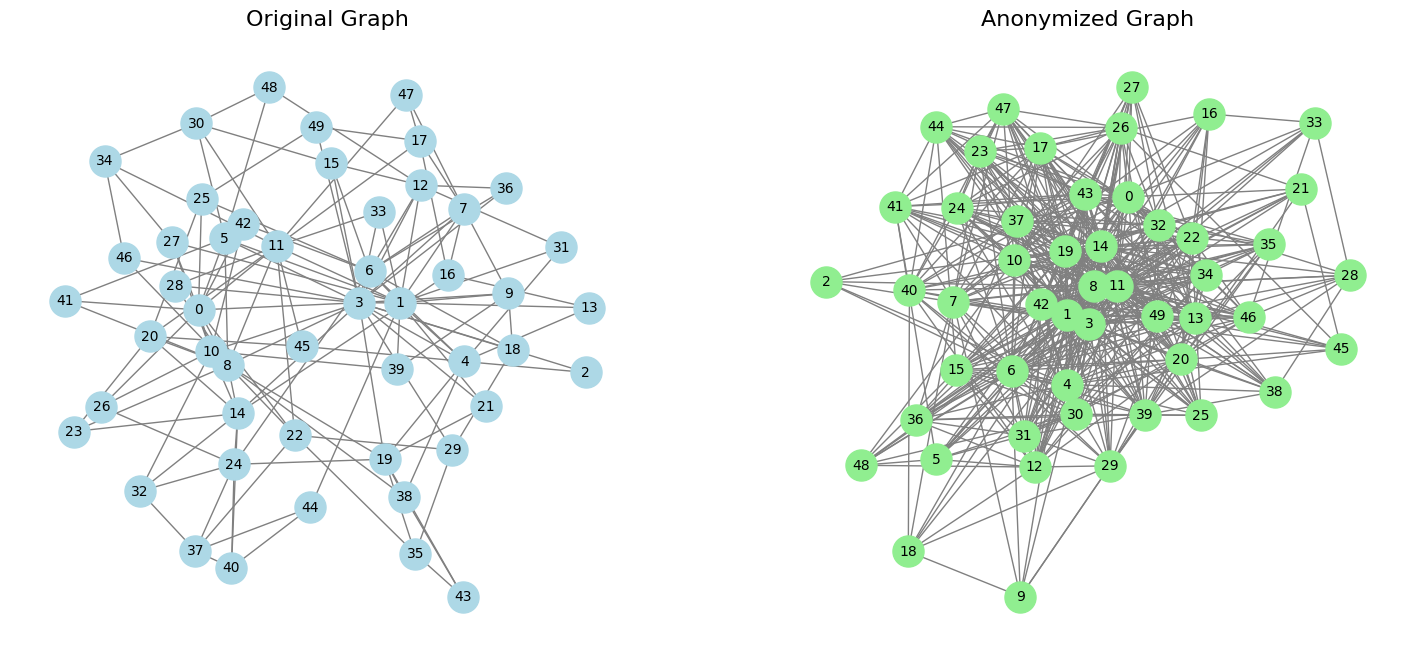

In [701]:
compare_graphs(graph, G, title1="Original Graph", title2="Anonymized Graph")


In [702]:
print("Original Graph:")
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Average clustering coefficient:", nx.average_clustering(graph))
print("Average shortest path length:", nx.average_shortest_path_length(graph))

print("\nAnonymized Graph:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average clustering coefficient:", nx.average_clustering(G))
print("Average shortest path length:", nx.average_shortest_path_length(G))


Original Graph:
Number of nodes: 50
Number of edges: 140
Average clustering coefficient: 0.39131524031524023
Average shortest path length: 2.3355102040816327

Anonymized Graph:
Number of nodes: 50
Number of edges: 519
Average clustering coefficient: 0.7121766789643833
Average shortest path length: 1.576326530612245


In [703]:
violations_percentage = compute_k_neighborhood_isomorphism_violations(
    graph, k_min=2, k_max=20, step=2, include_node_itself=False
)
for k, percentage in violations_percentage.items():
    print(f"Percentage of vertices violating {k}-neighborhood isomorphism: {percentage:.2f}%")
print()
violations_percentage = compute_k_neighborhood_isomorphism_violations(
    G, k_min=2, k_max=20, step=2, include_node_itself=False
)
for k, percentage in violations_percentage.items():
    print(f"Percentage of vertices violating {k}-neighborhood isomorphism: {percentage:.2f}%")

Percentage of vertices violating 2-neighborhood isomorphism: 44.00%
Percentage of vertices violating 4-neighborhood isomorphism: 72.00%
Percentage of vertices violating 6-neighborhood isomorphism: 72.00%
Percentage of vertices violating 8-neighborhood isomorphism: 84.00%
Percentage of vertices violating 10-neighborhood isomorphism: 100.00%
Percentage of vertices violating 12-neighborhood isomorphism: 100.00%
Percentage of vertices violating 14-neighborhood isomorphism: 100.00%
Percentage of vertices violating 16-neighborhood isomorphism: 100.00%
Percentage of vertices violating 18-neighborhood isomorphism: 100.00%
Percentage of vertices violating 20-neighborhood isomorphism: 100.00%

Percentage of vertices violating 2-neighborhood isomorphism: 100.00%
Percentage of vertices violating 4-neighborhood isomorphism: 100.00%
Percentage of vertices violating 6-neighborhood isomorphism: 100.00%
Percentage of vertices violating 8-neighborhood isomorphism: 100.00%
Percentage of vertices violatin

In [704]:
# average vertex degree
print('average vertex degree:', sum(dict(graph.degree()).values())/len(graph.nodes()))

print('average vertex degree:', sum(dict(G.degree()).values())/len(G.nodes()))

average vertex degree: 5.6
average vertex degree: 20.76


Number of nodes: 50
Number of edges: 140
Average degree: 5.60
Isolated nodes: 0
Number of self nodes: 0


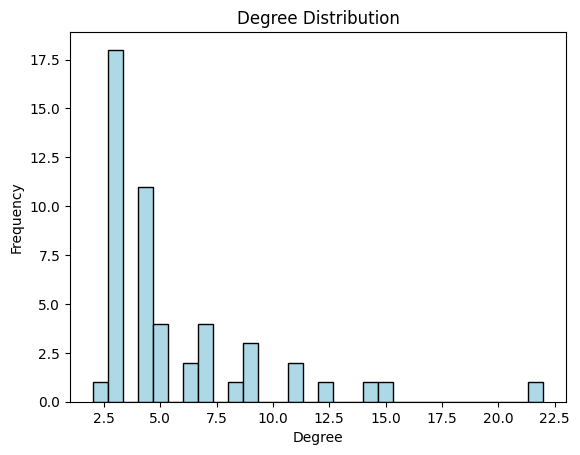

In [705]:
# Basic graph statistics
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")
print(f"Average degree: {sum(dict(graph.degree()).values()) / graph.number_of_nodes():.2f}")
print(f"Isolated nodes: {len(list(nx.isolates(graph)))}")
print(f"Number of self nodes: {nx.number_of_selfloops(graph)}")

# Degree distribution
degrees = [d for _, d in graph.degree()]
plt.hist(degrees, bins=30, color='lightblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Number of nodes: 50
Number of edges: 519
Average degree: 20.76
Isolated nodes: 0
Number of self nodes: 0


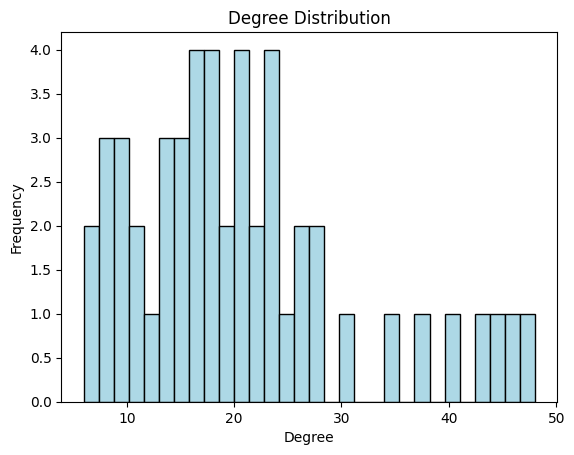

In [706]:
# Basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Isolated nodes: {len(list(nx.isolates(G)))}")
print(f"Number of self nodes: {nx.number_of_selfloops(G)}")

# Degree distribution
degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=30, color='lightblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()